In [1]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet
from glob import glob
import scipy.misc

Using TensorFlow backend.


In [2]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# with open('sim-data-capture/sim_data_large.yaml', 'r') as f:
#     df = pd.io.json.json_normalize(yaml.load(f))

# def parse_values(val):

#     if len(val) == 0:
#         return 'noColor'
#     else:
#         return (val[0]['class'])
    
# df['color'] = df.annotations.map(parse_values)
# df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
image_shape = (227,227)

shutil.rmtree('data/train/')
shutil.rmtree('data/valid/')
os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/Green')
os.mkdir('data/train/Red')
os.mkdir('data/train/Yellow')
os.mkdir('data/train/noColor')

os.mkdir('data/valid/Green')
os.mkdir('data/valid/Red')
os.mkdir('data/valid/Yellow')
os.mkdir('data/valid/noColor')

for color in ['Green','Yellow','Red','noColor']:
    
    files_simulator = glob('BiggerTrainingData/'+color+'/*.jpeg')
    np.random.shuffle(files_simulator)
    files_simulator = files_simulator[:int(0.25*len(files_simulator))]#data imbalance. only select 25% of the files
    print('Simulator '+color, len(files_simulator))

    files_real =glob('real_training_data/'+color+'/*.jpg')
    print('Real_Training '+color, len(files_real))
    files = files_simulator + files_real

    for filename in files:
        #print(filename)
        if np.random.rand(1)[0] < 0.8:
            directory = 'data/train/'+color+'/'

            shutil.copy(src= filename, dst=directory)
            
            path = os.path.join(directory, filename.split('/')[-1])
            imgg = scipy.misc.imresize(scipy.misc.imread(path), image_shape)# so data generator don't resize everytime
            scipy.misc.imsave(path,imgg[:,:,:3])
        else:    
            directory = 'data/valid/'+color+'/'
            shutil.copy(src= filename, dst=directory)
            
            path = os.path.join(directory, filename.split('/')[-1])
            imgg = scipy.misc.imresize(scipy.misc.imread(path), image_shape)
            scipy.misc.imsave(path,imgg[:,:,:3])


Simulator Green 259
Real_Training Green 325
Simulator Yellow 241
Real_Training Yellow 131
Simulator Red 249
Real_Training Red 186
Simulator noColor 272
Real_Training noColor 62


In [5]:
img_width, img_height = 227, 227
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 1024
nb_validation_samples = 256 
batch_size = 16
epochs = 100

In [6]:
#training data generator
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [7]:
#validation data generator
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)


In [8]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 1380 images belonging to 4 classes.


In [9]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 

class_mode = "categorical")

Found 345 images belonging to 4 classes.


In [70]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output
#reducing the size through convolutions so parameters stay reasonable
x = Dropout(0.5, name='drop9')(x)
x = Convolution2D(250, kernel_size=(3, 3), strides=(2,2), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.75)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00005), metrics=["accuracy"])


In [71]:
#model_final.summary()

### First 200 Epochs of training

In [72]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 125,# nb_train_samples/batch_size,
epochs = 200,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/200
125/125 [==============================] - 8s - loss: 5.1117 - acc: 0.2665 - val_loss: 1.5010 - val_acc: 0.3491
Epoch 2/200
125/125 [==============================] - 8s - loss: 2.3789 - acc: 0.2730 - val_loss: 1.3445 - val_acc: 0.3649
Epoch 3/200
125/125 [==============================] - 8s - loss: 1.7785 - acc: 0.2730 - val_loss: 1.3547 - val_acc: 0.3506
Epoch 4/200
125/125 [==============================] - 8s - loss: 1.6701 - acc: 0.2720 - val_loss: 1.3716 - val_acc: 0.2347
Epoch 5/200
125/125 [==============================] - 8s - loss: 1.5719 - acc: 0.2895 - val_loss: 1.3862 - val_acc: 0.2151
Epoch 6/200
125/125 [==============================] - 8s - loss: 1.4987 - acc: 0.2825 - val_loss: 1.3548 - val_acc: 0.3546
Epoch 7/200
125/125 [==============================] - 8s - loss: 1.4860 - acc: 0.2890 - val_loss: 1.3552 - val_acc: 0.4083
Epoch 8/200
125/125 [==============================] - 8s - loss: 1.4441 - acc: 0.2925 - val_loss: 1.3430 - val_acc: 0.3625
Epoch 9/

125/125 [==============================] - 7s - loss: 0.8471 - acc: 0.6040 - val_loss: 0.9013 - val_acc: 0.6174
Epoch 66/200
125/125 [==============================] - 7s - loss: 0.8538 - acc: 0.6005 - val_loss: 1.0096 - val_acc: 0.5817
Epoch 67/200
125/125 [==============================] - 7s - loss: 0.8596 - acc: 0.6075 - val_loss: 0.8572 - val_acc: 0.6574
Epoch 68/200
125/125 [==============================] - 7s - loss: 0.8470 - acc: 0.6160 - val_loss: 0.8369 - val_acc: 0.6371
Epoch 69/200
125/125 [==============================] - 8s - loss: 0.8419 - acc: 0.6215 - val_loss: 0.7832 - val_acc: 0.64340.
Epoch 70/200
125/125 [==============================] - 8s - loss: 0.8289 - acc: 0.6330 - val_loss: 0.8754 - val_acc: 0.6016
Epoch 71/200
125/125 [==============================] - 8s - loss: 0.8131 - acc: 0.6230 - val_loss: 0.7818 - val_acc: 0.7120
Epoch 72/200
125/125 [==============================] - 8s - loss: 0.8125 - acc: 0.6370 - val_loss: 0.7708 - val_acc: 0.7151
Epoch 73/20

125/125 [==============================] - 7s - loss: 0.4416 - acc: 0.8135 - val_loss: 0.3991 - val_acc: 0.8442
Epoch 131/200
125/125 [==============================] - 7s - loss: 0.4267 - acc: 0.8225 - val_loss: 0.4113 - val_acc: 0.8466
Epoch 132/200
125/125 [==============================] - 8s - loss: 0.3978 - acc: 0.8320 - val_loss: 0.3726 - val_acc: 0.8580
Epoch 133/200
125/125 [==============================] - 7s - loss: 0.4061 - acc: 0.8305 - val_loss: 0.4643 - val_acc: 0.8304
Epoch 134/200
125/125 [==============================] - 7s - loss: 0.4108 - acc: 0.8350 - val_loss: 0.4413 - val_acc: 0.8347
Epoch 135/200
125/125 [==============================] - 8s - loss: 0.4100 - acc: 0.8250 - val_loss: 0.3406 - val_acc: 0.8718
Epoch 136/200
125/125 [==============================] - 8s - loss: 0.3883 - acc: 0.8435 - val_loss: 0.3918 - val_acc: 0.8402
Epoch 137/200
125/125 [==============================] - 8s - loss: 0.4027 - acc: 0.8255 - val_loss: 0.4496 - val_acc: 0.8327
Epoch 

125/125 [==============================] - 8s - loss: 0.2675 - acc: 0.8795 - val_loss: 0.2921 - val_acc: 0.8825
Epoch 196/200
125/125 [==============================] - 8s - loss: 0.2366 - acc: 0.8965 - val_loss: 0.3494 - val_acc: 0.8738
Epoch 197/200
125/125 [==============================] - 10s - loss: 0.2547 - acc: 0.8830 - val_loss: 0.4005 - val_acc: 0.8935
Epoch 198/200
125/125 [==============================] - 8s - loss: 0.2471 - acc: 0.8885 - val_loss: 0.3793 - val_acc: 0.8619
Epoch 199/200
125/125 [==============================] - 8s - loss: 0.2304 - acc: 0.8995 - val_loss: 0.3187 - val_acc: 0.8659
Epoch 200/200
125/125 [==============================] - 8s - loss: 0.2488 - acc: 0.8890 - val_loss: 0.3513 - val_acc: 0.8625


### Another 200 Epochs of training

In [73]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 250,# nb_train_samples/batch_size,
epochs = 200,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/200
250/250 [==============================] - 15s - loss: 0.2551 - acc: 0.8845 - val_loss: 0.3094 - val_acc: 0.8718
Epoch 2/200
250/250 [==============================] - 15s - loss: 0.2308 - acc: 0.8920 - val_loss: 0.2836 - val_acc: 0.8679
Epoch 3/200
250/250 [==============================] - 15s - loss: 0.2388 - acc: 0.8990 - val_loss: 0.3218 - val_acc: 0.8526
Epoch 4/200
250/250 [==============================] - 15s - loss: 0.2397 - acc: 0.8955 - val_loss: 0.3114 - val_acc: 0.8679
Epoch 5/200
250/250 [==============================] - 15s - loss: 0.2456 - acc: 0.8998 - val_loss: 0.3178 - val_acc: 0.8785
Epoch 6/200
250/250 [==============================] - 15s - loss: 0.2428 - acc: 0.8893 - val_loss: 0.2928 - val_acc: 0.8865
Epoch 7/200
250/250 [==============================] - 15s - loss: 0.2182 - acc: 0.9035 - val_loss: 0.3448 - val_acc: 0.8679
Epoch 8/200
250/250 [==============================] - 15s - loss: 0.2180 - acc: 0.9055 - val_loss: 0.3782 - val_acc: 0.8606


250/250 [==============================] - 14s - loss: 0.1470 - acc: 0.9353 - val_loss: 0.2875 - val_acc: 0.9263
Epoch 67/200
250/250 [==============================] - 14s - loss: 0.1315 - acc: 0.9395 - val_loss: 0.3127 - val_acc: 0.9152
Epoch 68/200
250/250 [==============================] - 14s - loss: 0.1400 - acc: 0.9330 - val_loss: 0.3410 - val_acc: 0.9132
Epoch 69/200
250/250 [==============================] - 14s - loss: 0.1368 - acc: 0.9402 - val_loss: 0.3456 - val_acc: 0.9243
Epoch 70/200
250/250 [==============================] - 14s - loss: 0.1330 - acc: 0.9390 - val_loss: 0.3313 - val_acc: 0.9132
Epoch 71/200
250/250 [==============================] - 14s - loss: 0.1291 - acc: 0.9425 - val_loss: 0.3143 - val_acc: 0.9283
Epoch 72/200
250/250 [==============================] - 15s - loss: 0.1303 - acc: 0.9475 - val_loss: 0.3230 - val_acc: 0.9343
Epoch 73/200
250/250 [==============================] - 14s - loss: 0.1416 - acc: 0.9385 - val_loss: 0.2392 - val_acc: 0.9487
Epoch

250/250 [==============================] - 16s - loss: 0.1021 - acc: 0.9565 - val_loss: 0.2233 - val_acc: 0.9586
Epoch 131/200
250/250 [==============================] - 15s - loss: 0.0979 - acc: 0.9610 - val_loss: 0.3819 - val_acc: 0.9329
Epoch 132/200
250/250 [==============================] - 15s - loss: 0.0993 - acc: 0.9585 - val_loss: 0.2885 - val_acc: 0.9502
Epoch 133/200
250/250 [==============================] - 15s - loss: 0.0943 - acc: 0.9608 - val_loss: 0.3614 - val_acc: 0.9389
Epoch 134/200
250/250 [==============================] - 14s - loss: 0.1020 - acc: 0.9582 - val_loss: 0.3253 - val_acc: 0.9329
Epoch 135/200
250/250 [==============================] - 14s - loss: 0.1000 - acc: 0.9607 - val_loss: 0.2931 - val_acc: 0.9602
Epoch 136/200
250/250 [==============================] - 15s - loss: 0.0999 - acc: 0.9598 - val_loss: 0.2983 - val_acc: 0.9448
Epoch 137/200
250/250 [==============================] - 14s - loss: 0.0951 - acc: 0.9582 - val_loss: 0.3210 - val_acc: 0.950

250/250 [==============================] - 14s - loss: 0.0712 - acc: 0.9705 - val_loss: 0.3780 - val_acc: 0.9467
Epoch 195/200
250/250 [==============================] - 15s - loss: 0.0765 - acc: 0.9687 - val_loss: 0.2997 - val_acc: 0.9442
Epoch 196/200
250/250 [==============================] - 15s - loss: 0.0824 - acc: 0.9657 - val_loss: 0.2894 - val_acc: 0.9487
Epoch 197/200
250/250 [==============================] - 15s - loss: 0.0743 - acc: 0.9670 - val_loss: 0.3027 - val_acc: 0.9527
Epoch 198/200
250/250 [==============================] - 15s - loss: 0.0678 - acc: 0.9697 - val_loss: 0.3999 - val_acc: 0.9442
Epoch 199/200
250/250 [==============================] - 15s - loss: 0.0849 - acc: 0.9675 - val_loss: 0.3608 - val_acc: 0.9408
Epoch 200/200
250/250 [==============================] - 15s - loss: 0.0675 - acc: 0.9727 - val_loss: 0.3594 - val_acc: 0.9448


### Another 50 Epochs of training

In [76]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 250,# nb_train_samples/batch_size,
epochs = 50,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/50
250/250 [==============================] - 14s - loss: 0.0828 - acc: 0.9695 - val_loss: 0.2859 - val_acc: 0.9422
Epoch 2/50
250/250 [==============================] - 15s - loss: 0.0705 - acc: 0.9730 - val_loss: 0.3620 - val_acc: 0.9408
Epoch 3/50
250/250 [==============================] - 15s - loss: 0.0771 - acc: 0.9675 - val_loss: 0.3700 - val_acc: 0.9462
Epoch 4/50
250/250 [==============================] - 15s - loss: 0.0833 - acc: 0.9638 - val_loss: 0.3967 - val_acc: 0.9422
Epoch 5/50
250/250 [==============================] - 15s - loss: 0.0725 - acc: 0.9705 - val_loss: 0.3446 - val_acc: 0.9428
Epoch 6/50
250/250 [==============================] - 14s - loss: 0.0708 - acc: 0.9720 - val_loss: 0.2951 - val_acc: 0.9402
Epoch 7/50
250/250 [==============================] - 15s - loss: 0.0854 - acc: 0.9690 - val_loss: 0.3681 - val_acc: 0.9270
Epoch 8/50
250/250 [==============================] - 14s - loss: 0.0798 - acc: 0.9687 - val_loss: 0.4017 - val_acc: 0.9310
Epoch 9/

### Saved the model

In [102]:

models_folder_path = ''
model_name = 'squeezenet_transfer_learned_real_and_simulator'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

# serialize model to JSON
model_json = model_final.to_json()
with open(arch_path, "w") as json_file:
    json_file.write(model_json)
print('Model architecture saved: ' + arch_path)
    
# serialize weights to HDF5
model_final.save_weights(weights_path)
print('Weights saved: ' + weights_path)

model.save('model_checkpoint.h5')
print('Model checkpoint saved: model_checkpoint.h5')

Model architecture saved: squeezenet_transfer_learned_real_and_simulator_architecture.json
Weights saved: squeezenet_transfer_learned_real_and_simulator_weights.h5
Model checkpoint saved: model_checkpoint.h5


### Load the model

In [10]:

models_folder_path = ''
model_name = 'squeezenet_transfer_learned_real_and_simulator'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

In [11]:
from keras.models import model_from_json

# load architecture
json_file = open(arch_path)
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights(weights_path)

print("Model loaded")

Model loaded


### Check loaded model

In [12]:

validation_generator = train_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

images, labels = next(validation_generator)
print('Validation samples: {}'.format(len(labels)))

Found 345 images belonging to 4 classes.
Validation samples: 32


In [39]:
# #to check one category of images
# images = []
# for img in glob('data/valid/Yellow/*.jpeg'):
#     images.append(scipy.misc.imread(img)/255.0)
    

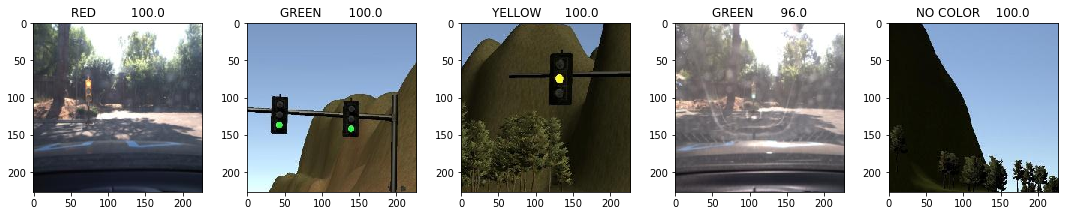

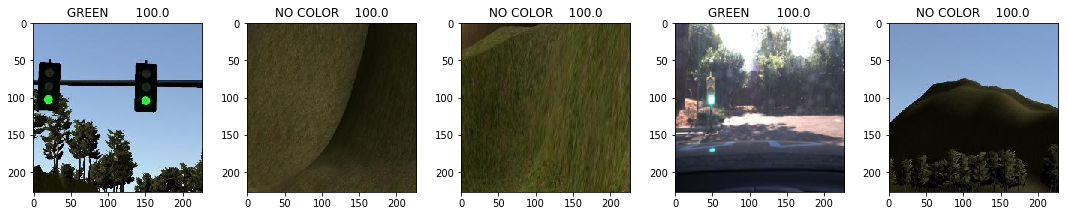

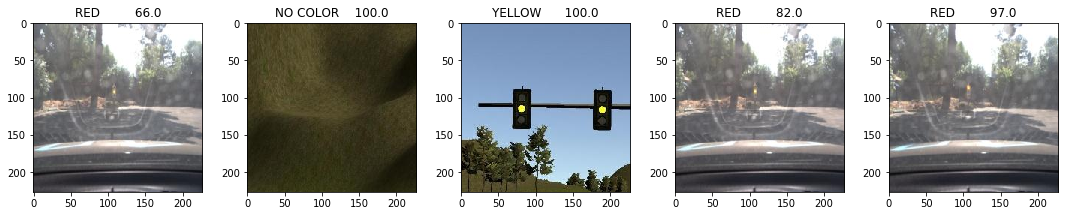

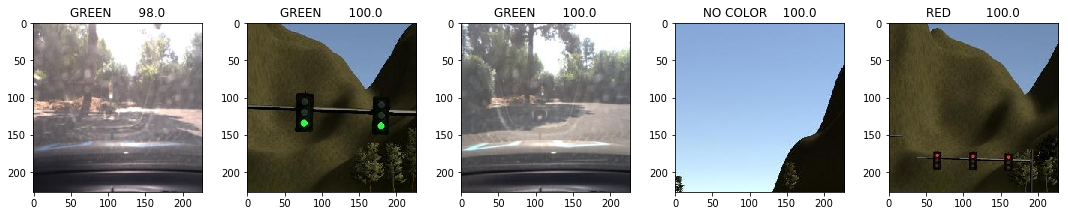

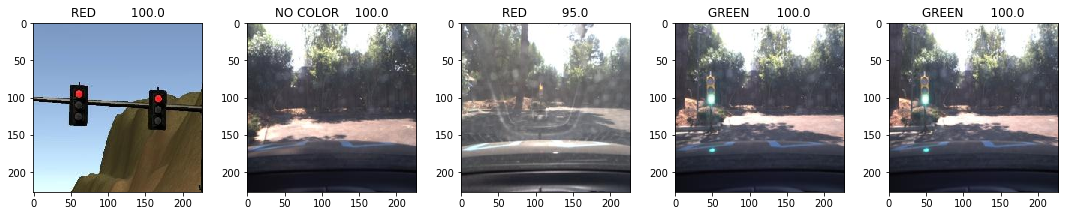

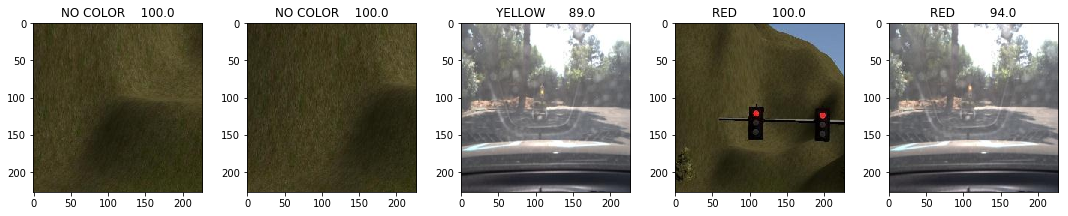

In [13]:
traffic_light_states = ['GREEN', 'RED', 'YELLOW', 'NO COLOR']

for i in range(int(len(images)/5.0)):

    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 6))
    f.tight_layout()
    
    prediction = loaded_model.predict(np.array([images[(5*i) + 0]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax1.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax1.imshow(images[(5*i) + 0])

    prediction = loaded_model.predict(np.array([images[(5*i) + 1]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax2.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax2.imshow(images[(5*i) + 1])

    prediction = loaded_model.predict(np.array([images[(5*i) + 2]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax3.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax3.imshow(images[(5*i) + 2])

    prediction = loaded_model.predict(np.array([images[(5*i) + 3]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax4.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax4.imshow(images[(5*i) + 3])

    prediction = loaded_model.predict(np.array([images[(5*i) + 4]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax5.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax5.imshow(images[(5*i) + 4])
